In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(
    log_dir=f"{root_dir}/results/logs",
    log_name="TDM",
)
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")
logger.info(f"Using device: {device}")

2025-11-24 11:19:36,844 - INFO - Logger initialized for 'TDM_20251124_111936'
2025-11-24 11:19:36,845 - INFO - Using device: cuda:0


In [2]:
full_dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="small",
    logger=logger
).optimize_memory().encode(attack_encoder="label").scale(scaler="minmax")

2025-11-24 11:19:36,853 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-24 11:19:37,361 - INFO - Loading dataset into DataFrame
2025-11-24 11:19:51,162 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-24 11:20:06,576 - INFO - ============================================================
2025-11-24 11:20:06,577 - INFO - Preprocessing completed successfully
2025-11-24 11:20:06,577 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-24 11:20:06,578 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-24 11:20:06,578 - INFO - data retention rate: 87.73%
2025-11-24 11:20:06,578 - INFO - ============================================================
2025-11-24 11:20:06,579 - INFO - Optimizing memory usage of the dataset...
2025-11-24 11:20:06,582 - INFO - Initial memory usage: 1067.15 MB
2025-11-24 11:20:07,370 - INFO - Optimized memory usage: 555.81 MB
2025-11-24 11:20:07,370 - INFO - Memory reduction: 511.34 MB (47.92%)
20

In [3]:
dataset = full_dataset.subset(size=50000, multi_class=False)

X_train, X_val, y_train, y_val = dataset.split(
    one_hot=True,
    apply_smote=False,
    to_tensor=True
)

# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

2025-11-24 11:20:31,122 - INFO - Subsetting dataset to size: 50000...
2025-11-24 11:20:31,131 - INFO - Class distribution before subsetting:
2025-11-24 11:20:31,132 - INFO -   Class 0: 1528113 samples
2025-11-24 11:20:31,133 - INFO -   Class 1: 414580 samples
2025-11-24 11:20:31,197 - INFO - Subsetted dataset to size: 50000
2025-11-24 11:20:31,269 - INFO - Splitting dataset into training and testing sets...
2025-11-24 11:20:31,320 - INFO - Class distribution before SMOTE:
2025-11-24 11:20:31,321 - INFO -   Class 0.0: 19942 samples
2025-11-24 11:20:31,322 - INFO -   Class 1.0: 20058 samples
2025-11-24 11:20:31,323 - INFO - Class distribution after SMOTE:
2025-11-24 11:20:31,323 - INFO -   Class 0.0: 19942 samples
2025-11-24 11:20:31,324 - INFO -   Class 1.0: 20058 samples


In [15]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input Size: {input_size}, Num Classes: {num_classes}")

model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=num_classes).to(device)
model_mlp = model_mlp.load_model(f"{root_dir}/NIDS_attacks/pytorch_attack/MLP_CICIDS2017_70x2_100.pt")

Input Size: 70, Num Classes: 2


2025-11-24 11:38:04,180 - INFO - Running analysis for PyTorch model: Model on device: cuda:0


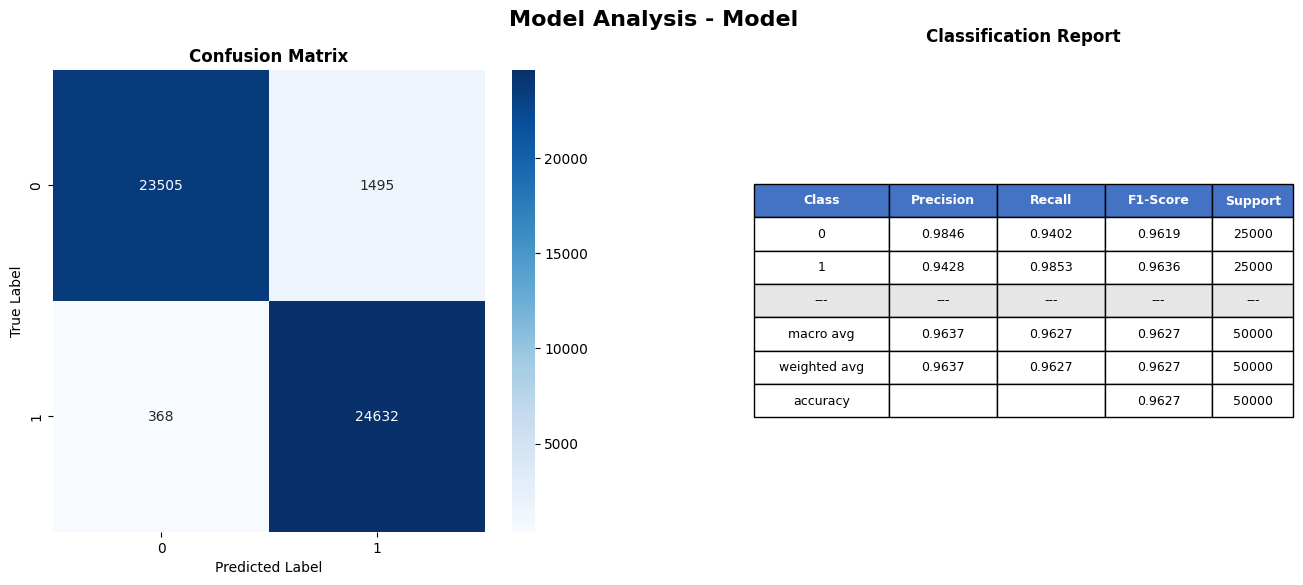

In [16]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=torch.vstack((X_train, X_val)).to(device),
    y_test=torch.vstack((y_train, y_val)).to(device),
    logger=logger,
    save_fig=False,
    plot=True,
    device=device
)

In [21]:
# Let's define our adversarial input: 
# it is a copy of our original input, and we will need to be able to compute the gradient with respect to that input

attack_indices = dataset.is_attack[dataset.is_attack == 1].index.tolist()
random_idx = torch.randperm(len(attack_indices))[0]

adversarial_attack_input = dataset.features.iloc[attack_indices[random_idx]].values

# To Tensor
adversarial_attack_input = torch.FloatTensor(adversarial_attack_input).clone().detach().requires_grad_(True)
adversarial_attack_input = adversarial_attack_input.unsqueeze(0).to(device)

print("Original input:", adversarial_attack_input)

Original input: tensor([[1.2207e-03, 1.2210e-03, 9.1009e-06, 2.0553e-05, 2.7287e-05, 1.7690e-05,
         1.4182e-02, 0.0000e+00, 1.9750e-02, 2.8521e-02, 3.7071e-01, 0.0000e+00,
         3.3316e-01, 3.4728e-01, 8.5283e-02, 3.3334e-01, 1.5272e-04, 5.4996e-04,
         1.1101e-03, 1.4167e-07, 1.0824e-04, 5.4121e-05, 1.0848e-04, 1.0820e-04,
         1.4167e-07, 1.2201e-03, 2.4401e-04, 6.9129e-04, 1.1100e-03, 2.5000e-08,
         0.0000e+00, 0.0000e+00, 9.9760e-01, 9.6637e-01, 6.8254e-06, 2.0476e-05,
         0.0000e+00, 2.9170e-01, 4.8644e-01, 4.9190e-01, 2.4183e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.2821e-02, 3.6033e-01, 1.9750e-02, 3.3316e-01, 9.9760e-01,
         9.1009e-06, 2.7350e-05, 2.0553e-05, 1.7690e-05, 4.4557e-01, 3.6011e-03,
         4.6826e-06, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<T

In [22]:
adversarial_attack_input = adversarial_attack_input.clone().detach().requires_grad_(True)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([0]).to(device)

model_mlp.eval()
epsilon = 1e-2

for iter in range(100):
    output = model_mlp(adversarial_attack_input)
    loss = criterion(output, target)

    print(f"Iter {iter}: probs: {torch.softmax(output, dim=1).detach().cpu().numpy()}, Loss: {loss.item()}")

    adversarial_attack_input.grad = None
    loss.backward()

    with torch.no_grad():
        adversarial_attack_input -= epsilon * adversarial_attack_input.grad
        # optional: clamp / project adversarial_attack_input here

    # ensure it's still a leaf with grad enabled for next iter
    adversarial_attack_input.requires_grad_(True)

Iter 0: probs: [[6.949042e-07 9.999993e-01]], Loss: 14.179491996765137
Iter 1: probs: [[1. 0.]], Loss: 0.0
Iter 2: probs: [[1. 0.]], Loss: 0.0
Iter 3: probs: [[1. 0.]], Loss: 0.0
Iter 4: probs: [[1. 0.]], Loss: 0.0
Iter 5: probs: [[1. 0.]], Loss: 0.0
Iter 6: probs: [[1. 0.]], Loss: 0.0
Iter 7: probs: [[1. 0.]], Loss: 0.0
Iter 8: probs: [[1. 0.]], Loss: 0.0
Iter 9: probs: [[1. 0.]], Loss: 0.0
Iter 10: probs: [[1. 0.]], Loss: 0.0
Iter 11: probs: [[1. 0.]], Loss: 0.0
Iter 12: probs: [[1. 0.]], Loss: 0.0
Iter 13: probs: [[1. 0.]], Loss: 0.0
Iter 14: probs: [[1. 0.]], Loss: 0.0
Iter 15: probs: [[1. 0.]], Loss: 0.0
Iter 16: probs: [[1. 0.]], Loss: 0.0
Iter 17: probs: [[1. 0.]], Loss: 0.0
Iter 18: probs: [[1. 0.]], Loss: 0.0
Iter 19: probs: [[1. 0.]], Loss: 0.0
Iter 20: probs: [[1. 0.]], Loss: 0.0
Iter 21: probs: [[1. 0.]], Loss: 0.0
Iter 22: probs: [[1. 0.]], Loss: 0.0
Iter 23: probs: [[1. 0.]], Loss: 0.0
Iter 24: probs: [[1. 0.]], Loss: 0.0
Iter 25: probs: [[1. 0.]], Loss: 0.0
Iter 26: prob